# Анализ оттока клиентов в «Метанпромбанке»

##  Описание проекта 
Главной задачей проекта является анализ оттока клиентов в «Метанпромбанке». Анализ покажет, какие клиенты уходят из банка, а так же поможет составить сегменты клиентов, которые склонны уходить из банка.
В отделе маркетинга нет автоматизированных систем рассылок, письма каждому клиенту пишутся вручную, поэтому важно для отдела маркетинга представить компактные однородные сегменты и дать примеры мероприятий, которые можно провести, чтобы вернуть клиентов в банк или удержать сомневающихся от оттока.

**Описание данных** 

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — оценочный доход клиента,
- сhurn — признак оттока.

##  Загрузим данные и изучим общую информацию 

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings
import plotly.express as px
import os
from plotly import graph_objects as go
register_matplotlib_converters()
import math as mth

In [2]:
#загрузка данных
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

df.head(15)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [3]:
#поставим пробел в названии столбца идентификатор пользователя
data=df.rename(columns = {'USERID':'user_id'})

In [4]:
#приведем название колонок к нижнему регистру
data.columns = map(str.lower, data.columns)

In [5]:
#проверим названия столбцов
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [6]:
#выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В датасете имеются пропуски и в некоторых колонках необходимо изменить тип данных. Сделаем это в следующем шаге.

##  Предобработка данных 

Для начала нужно изменить тип данных в столбце score и age : баллы кредитного скоринга и возраст лучше преобразовать в целое число.

In [7]:
data['age'] = data['age'].astype('Int64')
data['score'] = data['score'].astype('Int64') 

In [8]:
#проверим тип данных
data.dtypes

user_id            int64
score              Int64
city              object
gender            object
age                Int64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

Отлично. Типы соответствуют данным. Посмотрим теперь на полные дубликаты

In [9]:
data.duplicated().sum()

0

Полных дубликатов в датасете не имеется. Посмотрим на неявые дубликаты по идентификатору пользователя

In [10]:
data['user_id'].duplicated().sum()

73

Для нашего датасета 73 дубликатов не так много, можно их удалить, но прежде поищем дубликаты по столбцам возвраст и пол

In [11]:
data.duplicated(['user_id','gender', 'age']).sum()

2

Всего два дубликата. Посмотрим на них

In [12]:
data[data.duplicated(['user_id','gender', 'age'], False)]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863,Ярославль,М,30,5,1036114.50,5,1,1,150744.50,1
5197,155765,923,Рыбинск,М,30,0,NaN,1,1,1,120296.60,0
8205,227795,840,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1
8497,227795,839,Ярославль,М,34,2,326593.14,2,1,0,103314.92,0


Данные в этих дубликах отличаются. Можно предположить это один и тот же клиент, обратившийся в банк в разных городах. Возможно при выгрузке данных из разных городов произошел сбой.

In [13]:
# проверим есть ли дубликаты пользователй из одного города
data.duplicated(['user_id','city']).sum()

0

Как видим нет дубликов пользователей из одного города, это подтверждает наше предположение. В данном случае целесообразно оставить все как есть, так как дубликаты в колонке user_id не помещают анализу.

Закодируем столбцы city и gender для дальнейшего проведения анализа. Чтобы при этом не потерять оригинальный столбец, сделаем  копии.

In [14]:
data['city_2']=data['city']
data['gender_2']=data['gender']

In [15]:
# закодируем данные в столбцах city_2 и gender_2:

data = pd.get_dummies(data, columns = ['city_2', 'gender_2'])
data = data.rename (
    columns = ({
        'city_2_Ростов':'Ростов', 'city_2_Рыбинск':'Рыбинск','city_2_Ярославль':'Ярославль', 
        'gender_2_Ж':'female', 'gender_2_М':'male'}))
display(data.head())

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female,male
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


 Теперь посмотрим что за пропуски в колонках age и balance. 

In [16]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

user_id - 0.0%
score - 0.0%
city - 0.0%
gender - 0.0%
age - 0.26%
equity - 0.0%
balance - 22.95%
products - 0.0%
credit_card - 0.0%
last_activity - 0.0%
est_salary - 0.0%
churn - 0.0%
Ростов - 0.0%
Рыбинск - 0.0%
Ярославль - 0.0%
female - 0.0%
male - 0.0%


Пропуски в столбце age меньше 1%, можно их удалить. На результат исследование удаление не окажет сильного влияния.

In [17]:
data = data.dropna(subset = ['age'])

Изучим столбец 'balance'. Для начала посмотрим на эти пропуски.

In [18]:
data[data['balance'].isna()].head(15)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female,male
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
9,133130,906,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0,0,0,1,1,0
10,148929,927,Ростов,М,52,0,NaN,1,1,1,196820.07,0,1,0,0,0,1
11,172184,921,Ростов,М,41,0,NaN,1,1,1,217469.48,0,1,0,0,0,1
19,127034,922,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0,0,1,0,1,0
21,177415,896,Рыбинск,Ж,47,0,NaN,1,0,0,225060.35,0,0,1,0,1,0
30,155730,946,Ярославль,Ж,47,0,NaN,2,1,1,660015.85,0,0,0,1,1,0
34,205226,944,Ярославль,М,35,0,NaN,2,1,1,239843.39,0,0,0,1,0,1
39,173175,924,Рыбинск,Ж,51,0,NaN,1,1,1,248844.47,0,0,1,0,1,0
43,228585,956,Ростов,М,41,0,NaN,1,1,0,115117.10,0,1,0,0,0,1


Проверим не связан ли пропуск с оттоком.

In [19]:
data[data['balance'].isna()]['churn'].value_counts()

0    2266
1      13
Name: churn, dtype: int64

Как видим только в 13 значениях пропуск связан с оттоком. Посмотрим на корреляцию пропусков с остальными столбцами.

In [20]:
data.assign(missing = data.balance.isna()).corr()['missing'].drop('missing').sort_values(ascending=False,key=abs)

equity          -0.709036
products        -0.486232
est_salary       0.306957
churn           -0.248984
credit_card      0.157637
score            0.138762
male             0.062844
female          -0.062844
Ростов          -0.060583
Ярославль        0.056104
age             -0.028659
last_activity    0.028400
Рыбинск         -0.014566
user_id          0.002417
balance               NaN
Name: missing, dtype: float64

Видим множественные корреляции, значит нет возможности выделить какую-либо одну зависимость пропусков от остальных данных, поэтому мы не сможем выделить какой-либо один сегмент с линейной зависимостью и заполнить по ней пропуски. 
Можно только выделить сильную обратную  корреляцию с отточностью churn, количеством продуктов products и залоговой собственностью equity - это могут быть новые пользователи и поэтому у них ещё нет продуктов, счёта, и оценки собственности.
Сильная корреляция с наличием кредитной карты - это могут быть клиенты у которых из продуктов только кредитка и поэтому нет дебетового счёта.

Аномальные значения

В столбце products есть нулевое значение. Такого быть не должно. Посмотрим что это за клиенты

In [21]:
data[data['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female,male
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1,0,1,0


Эта единственная клиентка с Рыбинска, которая уже ушла от банка. Удалим эту анамолию. 

In [22]:
data=data[data['products']!=0]

В ходе предобработки данных в столбцах score и age изменили тип данных на соответвующую значениям в столбцах. Полных дубликатов в данных не обнаружилось, но были задвоенные идентификаторы пользователей. Которые решено было оставить без изменений. Так же закодировали столбцы city и gender для дальнейшего проведения анализа. Удалили пропуски в стоблце age, так как их было меньше 1%, а вот пропуски в столбце balance пришлось оставить без изменений. Большое количество, а именно 22.95%, было бы неправильно удалять. Взаимосвязи с каким-либо конкретным признаком не нашлось и поэтому мы не можем заменить эти пропуски, т.к. это приведёт к заметным искажениям.



В данном случае у нас тип пропуска MNAR  — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.  

##  Исследовательский анализ данных

Составим портрет типичного клиента по статусу оттока.

In [23]:
data_churn = data.groupby('churn').agg({'score': ['mean', 'median'], 'age': ['mean', 'median'], 'est_salary': ['mean', 'median'],
'balance': ['mean', 'median'], 'products': 'median', 'equity': 'median',
'city': pd.Series.mode, 'gender' : pd.Series.mode,
'credit_card' : 'mean', 'last_activity' : 'mean', 
'churn' : 'count'})
data_churn

score               age            est_salary             \
             mean median       mean median           mean     median   
churn                                                                  
0      845.396199  848.0  43.020846   40.0  147674.637881  118227.60   
1      863.361936  866.0  41.429593   39.0  148357.483157  125408.88   

            balance            products equity       city gender credit_card  \
               mean     median   median median       mode   mode        mean   
churn                                                                          
0      7.330316e+05  475410.09        2      3  Ярославль      Ж    0.708890   
1      1.134458e+06  783908.90        2      4  Ярославль      М    0.551705   

      last_activity churn  
               mean count  
churn                      
0          0.482894  8155  
1          0.702420  1818

Какие выводы можно сделать:
- количество баллов собственности у ушедших клиентов больше;
- продуктов равны;
- кредитных карт у ушедших меньше;
- активность у ушедших клиентов ниже;
- по городам отток выше у Ярославля;
- женщины меньше уходят мужчин;
- баллы кредитного скоринга можно сказать одинаковое;
- средний возраст тоже несильно отличается;
- баланс на счете выше у отточных клиентов;
- доход незначительно выше у ушедших клиентов.

In [24]:
# сравним центральные тенденции характеристик отточных и неотточных клиентов
data_churn=data_churn.drop(['city', 'gender'], axis=1)
pd.concat({'Не отточные': data_churn.iloc[0],
    'Отточные': data_churn.iloc[1],
    'Относительная разница %':(data_churn.iloc[1]/data_churn.iloc[0]-1)*100},
    axis=1).sort_values('Относительная разница %')

Не отточные        Отточные Относительная разница %
churn         count            8155            1818              -77.706928
credit_card   mean          0.70889        0.551705              -22.173401
age           mean        43.020846       41.429593               -3.698796
              median           40.0            39.0                    -2.5
products      median              2               2                     0.0
est_salary    mean    147674.637881   148357.483157                0.462398
score         median          848.0           866.0                2.122642
              mean       845.396199      863.361936                2.125126
est_salary    median       118227.6       125408.88                6.074115
equity        median              3               4               33.333333
last_activity mean         0.482894         0.70242               45.460566
balance       mean    733031.630149  1134458.209291               54.762518
              median      475410.09        783908.9               64.891094

Наиболее сильная отточность проявляется в balance, credit_card и last_activity. 

Посмотрим отточность по городам

In [25]:
data.groupby('city')['user_id'].count()/data['user_id'].count()*100

city
Ростов       14.198336
Рыбинск      26.892610
Ярославль    58.909054
Name: user_id, dtype: float64

Больше всего клиентов в Ярославле. В Ростове меньше всего клиентов, а Рыбинск занял среднюю позицию в данном рейтинге.

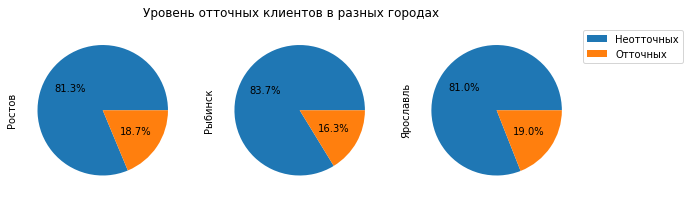

In [26]:
figure, axis = plt.subplots(1,3, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов в разных городах");

data.groupby('churn').agg({'Ростов': 'sum'}).plot(ax=axis[0],kind='pie',y='Ростов',autopct='%0.1f%%',legend=False,labeldistance=None);
data.groupby('churn').agg({'Рыбинск': 'sum'}).plot(ax=axis[1],kind='pie',y='Рыбинск',autopct='%0.1f%%',legend=False,labeldistance=None);
data.groupby('churn').agg({'Ярославль': 'sum'}).plot(ax=axis[2],kind='pie',y='Ярославль',autopct='%0.1f%%',legend=False,labeldistance=None);
axis[2].legend(['Неотточных','Отточных'], bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Доля ушедших клиентов не сильно отличается по городам. В Ярославле больше всего ушедших, затем в Ростове и меньше всего в Рыбинске.  В целом отток во всех городах примерно одинаковый

Изучим распределение по гендеру.

In [27]:
gender=(data.query('churn==1').groupby('gender')['user_id'].count()/data['churn'].sum()*100).round()
gender

gender
Ж    35.0
М    65.0
Name: user_id, dtype: float64

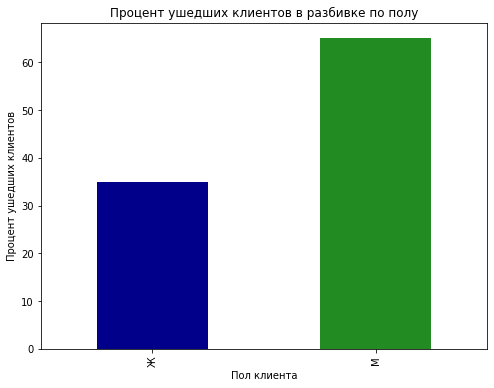

In [28]:
gender.plot(
    kind='bar', title = 'Процент ушедших клиентов в разбивке по полу',
    xlabel = 'Пол клиента', ylabel = 'Процент ушедших клиентов', figsize = (8,6),
    color=['darkblue', 'forestgreen']);

Женщины показывают почти в два раза меньший процент оттока клиентов, чем мужчины.

Посмотрим на отток по возрасту.

In [29]:
# создадим функцию age_cat для распределения клиентов по возрастным группам

def age_cat(age):
    if 18 <= age <= 24:
        return '18-24'
    if 25 <= age <= 35:
        return '25-35'
    if 36 <= age <= 50:
        return '36-50'
    if 51 <= age <= 60:
        return '51-60'
    if 61 <= age:
        return '60+'
    
data['age_cat'] = data['age'].apply (age_cat)

In [30]:
churn_age = data.pivot_table (index = 'age_cat', values = 'churn', aggfunc =['count'])
churn_age.columns = churn_age.columns.droplevel(level=1)
churn_age.sort_values(by='count', ascending=False) 

,count
age_cat,
36-50,4072
25-35,3055
51-60,1578
60+,1032
18-24,236


Наиболее отточные группы 36-50 лет, менее 18-24.

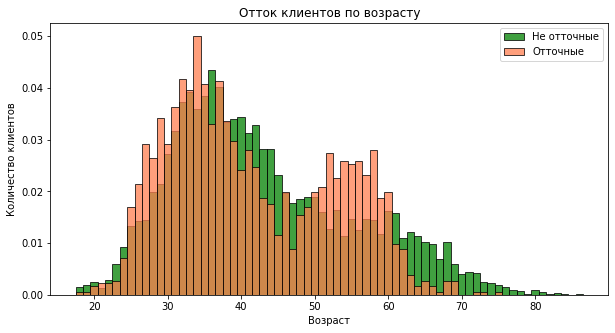

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data[data['churn'] == 0]['age'], discrete=True, stat='density', common_norm=False, color='green');
sns.histplot(data[data['churn'] == 1]['age'], discrete=True, stat='density', common_norm=False, color='coral');
plt.legend(['Не отточные', 'Отточные'])
plt.title('Отток клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

По графику видим, что пик оттока приходится на возраст примерно с 25 до 45 лет. Далее идет небольшой спад и затем в возрасте от 53 снова наблюдается рост оттока.

Теперь посмотрим на баланс ушедших клиентов.

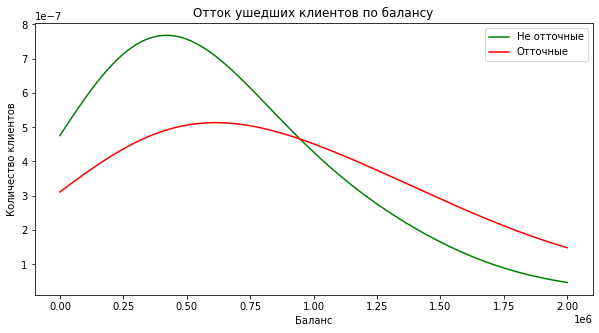

In [32]:
plt.figure(figsize=(10,5))
sns.kdeplot(data[data['churn'] == 0]['balance'], clip=(0.0, 2000000.0), common_norm=False, color='green')
sns.kdeplot(data[data['churn'] == 1]['balance'], clip=(0.0, 2000000.0), common_norm=False, color='red')
plt.legend(['Не отточные', 'Отточные'])
plt.title('Отток ушедших клиентов по балансу')
plt.xlabel('Баланс')
plt.ylabel('Количество клиентов')
plt.show()

Каких-либо пиковых значений на нашем графике нет. В начале идем небольшой рост, далее по мере возрастания дохода снижается отток.

Отток клиентов по доходу.

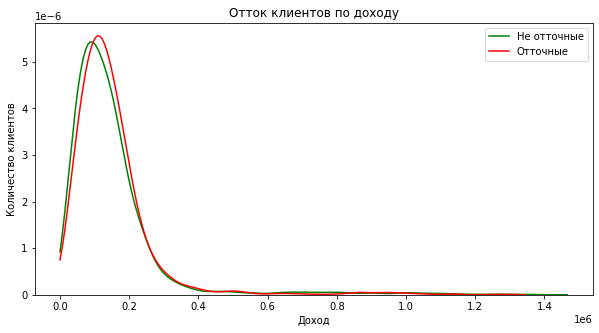

In [33]:
plt.figure(figsize=(10,5))
sns.kdeplot(data[data['churn'] == 0]['est_salary'], clip=(0.0, 2000000.0), common_norm=False, color='green')
sns.kdeplot(data[data['churn'] == 1]['est_salary'], clip=(0.0, 2000000.0), common_norm=False, color='red')
plt.legend(['Не отточные', 'Отточные'])
plt.title('Отток клиентов по доходу')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

По данному графику видим, что по доходу отточные и не отточные клиенты находятся на одном уровне.

Визуалируем теперь остальные признаки по оттоку.

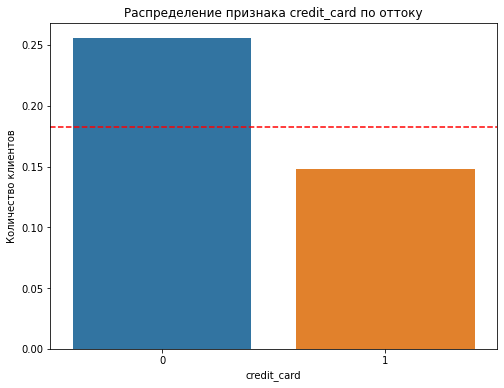

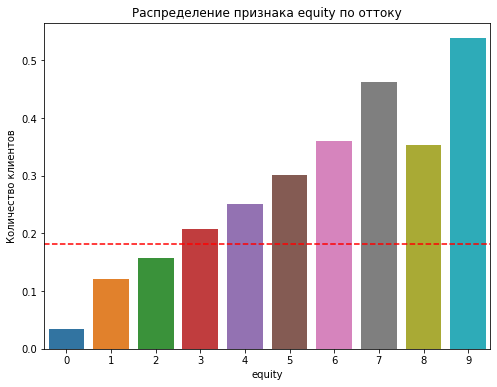

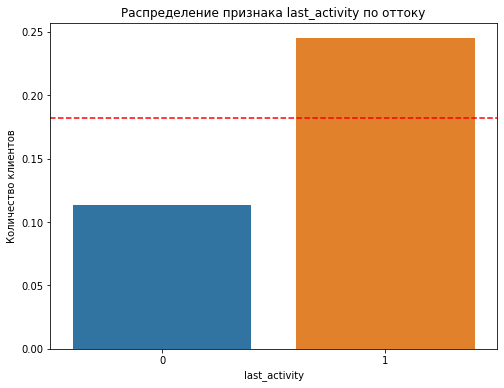

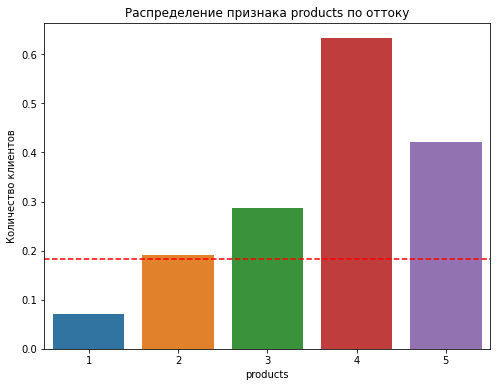

In [34]:
churn_mean=data['churn'].mean()

for column in ['credit_card', 'equity', 'last_activity', 'products']:
    levels=data.groupby(column).agg({'churn': 'mean'}).reset_index()
    plt.figure(figsize=(8, 6))
    sns.barplot(data=levels, x=column, y='churn')
    plt.title(f"Распределение признака {column} по оттоку")
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.axhline(y=churn_mean, color='red', linestyle='--') 
    plt.show()

Отток клиентов по баллу скоринга.

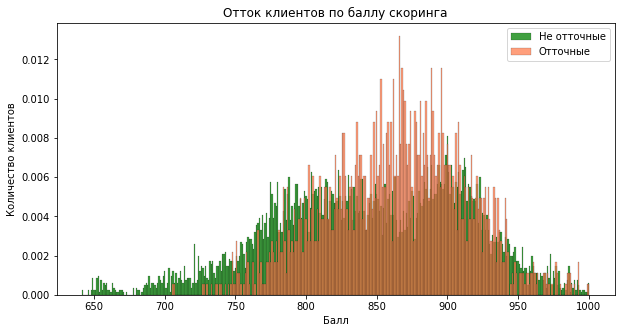

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(data[data['churn'] == 0]['score'], discrete=True, stat='density', common_norm=False, color='green');
sns.histplot(data[data['churn'] == 1]['score'], discrete=True, stat='density', common_norm=False, color='coral');
plt.legend(['Не отточные', 'Отточные'])
plt.title('Отток клиентов по баллу скоринга')
plt.xlabel('Балл')
plt.ylabel('Количество клиентов')
plt.show()

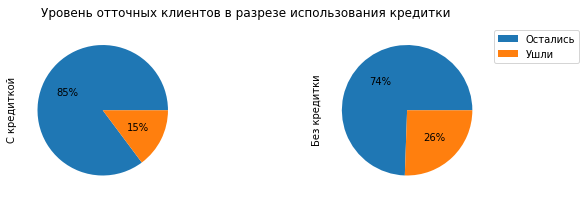

In [36]:
figure, axis = plt.subplots(1,2, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов в разрезе использования кредитки");

churn_level=data.groupby(['credit_card']).agg({'churn':'mean'})['churn']
axis[1].pie(x=[1 - churn_level.loc[0],churn_level.loc[0]],autopct='%.0f%%')
axis[0].pie(x=[1 - churn_level.loc[1],churn_level.loc[1]],autopct='%.0f%%')
axis[1].legend(['Остались','Ушли'], bbox_to_anchor=(1, 1.02), loc='upper left')
axis[0].set(ylabel='С кредиткой')
axis[1].set(ylabel='Без кредитки')
plt.show()

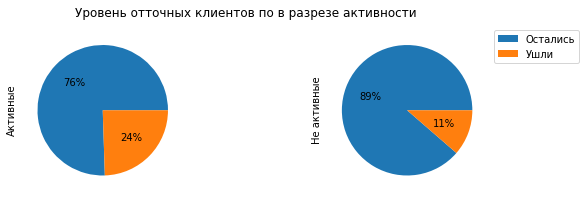

In [37]:
figure, axis = plt.subplots(1,2, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов по в разрезе активности");

churn_level=data.groupby(['last_activity']).agg({'churn':'mean'})['churn']
axis[1].pie(x=[1 - churn_level.loc[0],churn_level.loc[0]],autopct='%.0f%%')
axis[0].pie(x=[1 - churn_level.loc[1],churn_level.loc[1]],autopct='%.0f%%')
axis[1].legend(['Остались','Ушли'], bbox_to_anchor=(1, 1.02), loc='upper left')
axis[0].set(ylabel='Активные')
axis[1].set(ylabel='Не активные')
plt.show()

Выделим, на основе получившихся графиков, признаки оказывающие наибольшее влияние на отток клиентов:

- баллы кредитного рейтинга от 820 до 910
- баланс от 950K
- оценочный доход клиента от 100K до 230K
- возраст от 25 до 35 либо от 50 до 60
- баллов собственности больше или равно 3
- продуктов больше или равно 2
- пол больше мужчин
- кредитной карты нет
- активен 

Построим матрицу корреляций признаков клиентов.

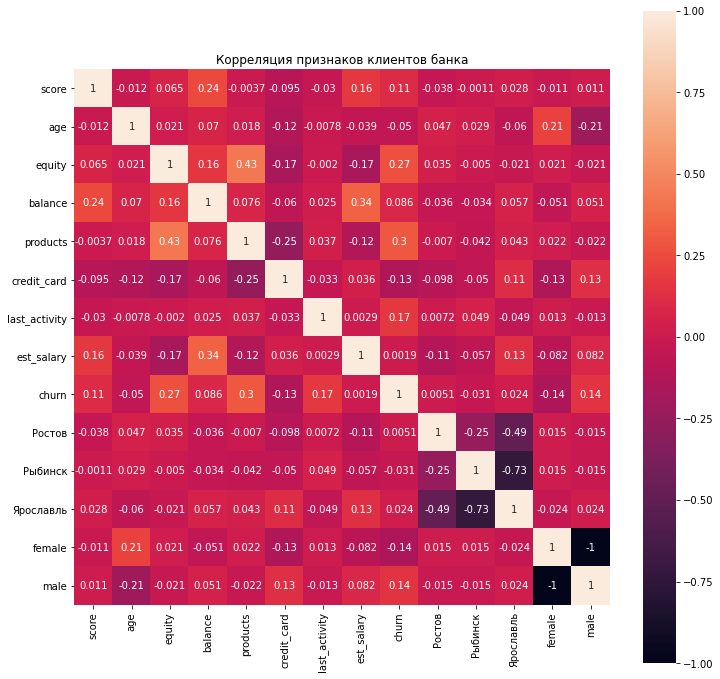

In [38]:
cm = data.drop('user_id', axis=1).corr()
fig, test = plt.subplots()
test.set_title('Корреляция признаков клиентов банка')
fig.set_figheight(12)
fig.set_figwidth(12)
sns.heatmap(cm, annot = True, square=True)
plt.show()

Судя по матрице, признаки практически не коррелируют между собой. Слабая положительная корреляция наблюдается между оттоком и возрастом. Слабая отрицательная связь видна у оттока и показателя активности клиента. Интересная, но слабая корреляция оттока по полу - для мужчин отрицательная, для женщин положительная. Слабая положительная корреляция между оттоком и городом Ростов и слабая отрицательная между оттоком и городом Ярославль.

##  Проверка статистических гипотез

Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.

H_0: доходы оставшихся и отточных клиентов равны;

H_1: доходы оставшихся и отточных клиентов не равны.

Для проверки гипотезы проведем t-test и u-test
alpha = 0.05 # критический уровень статистической значимости

<AxesSubplot:xlabel='est_salary', ylabel='Count'>

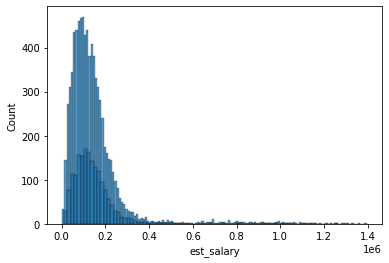

In [39]:
a = data[data['churn'] == 1]['est_salary']
b = data[data['churn'] == 0]['est_salary']
sns.histplot(data[data['churn'] == 0]['est_salary'])
sns.histplot(data[data['churn'] == 1]['est_salary'])

In [40]:
# проведём тест на соотвествие данных о доходах отточных клиентов нормальному распределеню

alpha = 0.05  # критический уровень статистической значимости

shapiro_test_stat, p_value = st.shapiro(a)

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  

p-значение:  0.0
Распределение не нормально


In [41]:
# проведём тест на соотвествие данных о доходах неотточных клиентов нормальному распределеню

alpha = 0.05  # критический уровень статистической значимости

shapiro_test_stat, p_value = st.shapiro(b)

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение') 

p-значение:  0.0
Распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [42]:
# оценим дисперсии

print(data[data['churn'] == 0]['est_salary'].var())
print(data[data['churn'] == 1]['est_salary'].var())

20358839437.943962
15112272166.883385


Как видим выборки не подходят для проведения t-testa, так как генеральные совокупности не зависят друг от друга;
распределение значений не является нормальным; дисперсии не равны.

При отсутствии нормального распределения сравниваемых выборок вместо t-критерия Стьюдента используются аналогичные методы непараметрической статистики, среди которых наиболее известными является U-критерий Манна — Уитни.


In [43]:
# проведем u-test

alpha = 0.05  

results = st.mannwhitneyu(a, b)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу


Таким образом, отвергаем нулевую гипотезу, доходы оставшихся и отточных клиентов не равны.

Гипотеза различия количества используемых банковских продуктов между теми клиентами, которые ушли и теми, которые остались.

H₀: среднее количество используемых банковских продуктов оставшихся и отточных клиентов равны

H₁: среднее количество используемых банковских продуктов оставшихся и отточных клиентов не равны

Для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам используем t-тест: scipy.stats.ttest_ind(array1, array2, egual_var). Уровень статитсической значимости возьмем 0.05

In [44]:
hyp = st.ttest_ind (
    data[data['churn']==0]['products'],
    data[data['churn']==1]['products'], equal_var = False)

alpha = 0.05

print (hyp.pvalue)

if hyp.pvalue < alpha:
    print ('Отвергаем нулевую гипотезу')
else:
    print ('Не получилось отвергнуть нулевую гипотезу')

1.2671065900765871e-138
Отвергаем нулевую гипотезу


Результаты t-теста указывают на то, что нулевая гипотеза о равенстве количества используемых банковских продуктов для разных групп клиентов должна быть отвергнута.

## Сегменты клиентов

Для предотвращения оттока выделим сегменты наиболее склонные к оттоку.

Сегмент №1
- Возраст 52 и более лет
- Баланс менее 800000
- Кредитный рейтинг более 825
- Активный

In [45]:
print ('Число пользователей в 1 сегменте -', data.query (
    'age < 52 and balance < 800000 and score > 825 and last_activity == 1')['user_id'].count())

print ('Число отточных пользователей в 1 сегменте -', data.query (
    'age < 52 and balance < 800000 and score > 825 and last_activity == 1 and churn == 1')['user_id'].count())

print ('Доля отточных пользователей в 1 сегменте -', (data.query (
    'age < 52 and balance < 800000 and score > 825  and last_activity == 1 and churn == 1')['user_id'].count() / data.query (
    'age < 52 and balance < 800000 and score > 825 and last_activity == 1 and churn == 0')['user_id'].count()*100).round(2))

Число пользователей в 1 сегменте - 951
Число отточных пользователей в 1 сегменте - 395
Доля отточных пользователей в 1 сегменте - 71.04


Этому сегменту можно предложить целевой кредит для пенсионеров.

Сегмент №2
- Возраст от 27 до 43 лет
- Баланс более 950,000
- Баллы собственности более 3

In [46]:
print ('Число пользователей во 2 сегменте -', data.query (
    '27 <= age <= 43 and equity >= 3 and balance > 950000')['user_id'].count())

print ('Число отточных пользователей во 2 сегменте -', data.query (
    '27 <= age <= 43 and equity >= 3 and balance > 950000 and churn == 1')['user_id'].count())

print ('Доля отточных пользователей во 2 сегменте -', (data.query (
    '27 <= age <= 43 and equity >= 3 and balance > 950000 and churn == 1')['user_id'].count() / data.query (
    '27 <= age <= 43 and equity >= 3 and balance > 950000 and churn == 0')['user_id'].count()*100).round(2))

Число пользователей во 2 сегменте - 934
Число отточных пользователей во 2 сегменте - 404
Доля отточных пользователей во 2 сегменте - 76.23


Для Сегмента 2 было бы интересно уникальные условия по накопительным счетам, а так же различные залоговые кредиты или страхования имущества.

Сегмент №3
- Город Ярославль
- Нет кредитной карты
- Активный

In [47]:
print ('Число пользователей в 3 сегменте -', data.query (
    'credit_card == 0 and last_activity == 1 and city == "Ярославль"')['user_id'].count())

print ('Число отточных пользователей в 3 сегменте -', data.query (
    'credit_card == 0 and last_activity == 1 and city == "Ярославль" and churn == 1')['user_id'].count())

print ('Доля отточных пользователей в 3 сегменте -', (data.query (
    'credit_card == 0 and last_activity == 1 and city == "Ярославль" and churn == 1')['user_id'].count() / data.query (
    'credit_card == 0 and last_activity == 1 and city == "Ярославль" and churn == 0')['user_id'].count()*100).round(2) )

Число пользователей в 3 сегменте - 843
Число отточных пользователей в 3 сегменте - 343
Доля отточных пользователей в 3 сегменте - 68.6


Сегмента 3 возможно заинтересует кредитная карта, либо дебетовая карта выгодным с кэшбэком.

Приоритизация сегментов.

По каждому сегменту было посчитанно доля отточных клиентов. Отделу маркетинга рекомендуется обратить внимания в первую очередь на те сегменты, где более высокий отток. В нашем случае чередность получиться такой:
- Сегмента 2 - доля отточных пользователей 76.23
- Сегмента 1 - доля отточных пользователей 71.04
- Сегмента 3 - доля отточных пользователей 68.6

## Вывод

Таким образом, была проведена большая работа по анализу оттока клиентов в «Метанпромбанке».

В ходе предобработки данных в столбцах score и age изменили тип данных на соответвующую значениям в столбцах. Полных дубликатов в данных не обнаружилось, но были задвоенные идентификаторы пользователей. Которые решено было оставить без изменений. Так же закодировали столбцы city и gender для дальнейшего проведения анализа. Удалили пропуски в стоблце age, так как их было меньше 1%, а вот пропуски в столбце balance пришлось оставить без изменений. Большое количество, а именно 22.95%, было бы неправильно удалять. Взаимосвязи с каким-либо конкретным признаком не нашлось и поэтому мы не можем заменить эти пропуски, т.к. это приведёт к заметным искажениям.

Провели исследовский анализ данных, где были сделаны следующие выводы:
- количество баллов собственности у ушедших клиентов больше;
- продуктов равны;
- кредитных карт у ушедших меньше;
- активность у ушедших клиентов ниже;
- по городам отток выше у Ярославля;
- женщины меньше уходят мужчин;
- баллы кредитного скоринга можно сказать одинаковое;
- средний возраст тоже несильно отличается;
- баланс на счете выше у отточных клиентов;
- доход незначительно выше у ушедших клиентов.

Доля ушедших клиентов не сильно отличается по городам. В Ярославле больше всего ушедших, затем в Ростове и меньше всего в Рыбинске.  В целом отток во всех городах примерно одинаковый. Женщины показывают почти в два раза меньший процент оттока клиентов, чем мужчины. Пик оттока приходится на возраст примерно с 25 до 45 лет. Далее идет небольшой спад и затем в возрасте от 53 снова наблюдается рост оттока. По матрице корреляции признаки практически не коррелируют между собой. Слабая положительная корреляция наблюдается между оттоком и возрастом. Слабая отрицательная связь видна у оттока и показателя активности клиента. Интересная, но слабая корреляция оттока по полу - для мужчин отрицательная, для женщин положительная. Слабая положительная корреляция между оттоком и городом Ростов и слабая отрицательная между оттоком и городом Ярославль.

Проверили гипотезы о различия дохода между теми клиентами, которые ушли и теми, которые остались и гипотезу различия количества используемых банковских продуктов между теми клиентами, которые ушли и теми, которые остались. Проверка показала, что доходы оставшихся и отточных клиентов не равны. А так же среднее количество используемых банковских продуктов оставшихся и отточных клиентов не равны. 

Для предотвращения оттока выделили три сегмента наиболее склонные к оттоку.

Сегмент №1: возраст 52 и более лет, баланс менее 800000, кредитный рейтинг более 825, активный.
Этому сегменту можно предложить целевой кредит для пенсионеров.

Сегмент №2: возраст от 27 до 43 лет, баланс более 950000, баллы собственности более 3.
Для Сегмента 2 было бы интересно уникальные условия по накопительным счетам, а так же различные залоговые кредиты или страхования имущества.

Сегмент №3: город Ярославль, нет кредитной карты, активный.
Сегмента 3 возможно заинтересует кредитная карта, либо дебетовая карта выгодным с кэшбэком.

##  Презентация

https://disk.yandex.ru/i/gpy8xIoq2wqLuA

## Дашборд

https://public.tableau.com/app/profile/zara.zara/viz/Bankiproject_16996502213870/Dashboard1?publish=yes